In [7]:
import requests
from tqdm.auto import tqdm

import faiss
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel

In [72]:
# %load_ext autoreload
# %autoreload 2
import embeddings

## Reference Lists

In [2]:

req = requests.get("https://raw.githubusercontent.com/CSAILVision/places365/master/categories_places365.txt")
places_list = [x.split(' ') for x in req.content.decode('utf-8').split('\n')]
places = ["_".join(x[0].split('/')[2:]).replace("_", " ") for x in places_list]
with open("places_365.txt", 'w') as f:
    f.write("\n".join(places))

In [113]:
oi = []
with open("2017_11/class-descriptions.csv") as f:
    for line in f:
        oi.append(line.strip())
        
with open('objects_open_images.txt', 'w') as f:
    f.write("\n".join([x.split(',')[-1] for x in oi]))

## Embeddings

In [8]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

In [5]:
image = Image.open('n02086240_7268.JPEG')
image_inputs = processor(images=image, return_tensors="pt", padding=True)
out = model.get_image_features(**image_inputs)

### Places

In [81]:
with open("places_365.txt") as f:
    places = f.read().split('\n')

In [82]:
inputs = processor(text=places, return_tensors="pt", padding=True)
places_embeddings = model.get_text_features(**inputs)

In [83]:
places_index = embeddings.FaissIndex(embedding_size=768, faiss_index_location='faiss_indices/places.index', indexer=faiss.IndexFlatIP)
places_index.reset()

INFO:embeddings:Setting embedding size (768) to match saved index


In [93]:
places_index2 = embeddings.FaissIndex(faiss_index_location='faiss_indices/places.index', indexer=faiss.IndexFlatIP)

INFO:embeddings:Setting embedding size (768) to match saved index


In [84]:
places_index.add(places_embeddings.detach().numpy(), places)

In [85]:
places_index.search(out.detach().numpy())

(array([[0.17297854, 0.15687369, 0.15423924, 0.15403895, 0.15325068,
         0.146204  , 0.1395231 , 0.13754925, 0.13722014, 0.13552675]],
       dtype=float32),
 array([[ 50, 346, 201, 173, 261, 303, 208, 155,  63, 221]]),
 ['beauty salon',
  'veterinarians office',
  'kennel outdoor',
  'hayfield',
  'pet shop',
  'shower',
  'laundromat',
  'galley',
  'bow window indoor',
  'manufactured home'])

### Objects

In [6]:
with open("objects_open_images.txt") as f:
    objects = f.read().split('\n')

In [7]:
objects_index = embeddings.FaissIndex(embedding_size=768, faiss_index_location='faiss_indices/objects.index', indexer=faiss.IndexFlatIP)

In [8]:
objects_index.reset()

In [9]:
batches = list(range(0, len(objects), 300)) + [len(objects)]

In [11]:
batched_objects = []
for idx in range(0,len(batches)-1):
    batched_objects.append(objects[batches[idx]:batches[idx+1]])

In [12]:

for batch in tqdm(batched_objects):
    inputs = processor(text=batch, return_tensors="pt", padding=True)
    objects_embeddings = model.get_text_features(**inputs)
    objects_index.add(objects_embeddings.detach().numpy(), batch)

  0%|          | 0/67 [00:00<?, ?it/s]

In [80]:
objects_index.search(out.detach().numpy())

(array([[0.2385486 , 0.21685846, 0.21458337, 0.21301875, 0.21031088,
         0.20976993, 0.20975675, 0.20324187, 0.1994285 , 0.19938366]],
       dtype=float32),
 array([[ 1128,  6936, 11958,  1844, 18549,  8918, 18977,  7881, 10819,
         18120]]),
 ['Home',
  'Ivy',
  'cymbal',
  'Black-and-white',
  'concept',
  'coupé',
  'Roller',
  'rice',
  'powder',
  'Vauxhall'])

## LLM

In [ ]:
import json
import requests
headers = {"Authorization": f"Bearer {API_TOKEN}"}
API_URL = "https://api-inference.huggingface.co/models/facebook/bart-large-cnn"
def query(payload):
    data = json.dumps(payload)
    response = requests.request("POST", API_URL, headers=headers, data=data)
    return json.loads(response.content.decode("utf-8"))
data = query(
    {
        "inputs": "The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and the tallest structure in Paris. Its base is square, measuring 125 metres (410 ft) on each side. During its construction, the Eiffel Tower surpassed the Washington Monument to become the tallest man-made structure in the world, a title it held for 41 years until the Chrysler Building in New York City was finished in 1930. It was the first structure to reach a height of 300 metres. Due to the addition of a broadcasting aerial at the top of the tower in 1957, it is now taller than the Chrysler Building by 5.2 metres (17 ft). Excluding transmitters, the Eiffel Tower is the second tallest free-standing structure in France after the Millau Viaduct.",
        "parameters": {"do_sample": False},
    }
)
# Response
self.assertEqual(
    data,
    [
        {
            "summary_text": "The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building. Its base is square, measuring 125 metres (410 ft) on each side. During its construction, the Eiffel Tower surpassed the Washington Monument to become the tallest man-made structure in the world.",
        },
    ],
)

In [37]:
class HuggingFaceHosted:
    def __init__(self, model_id, api_token):
        self.model_id = model_id
        self.api_token = api_token
        
    def query(self, data):
        headers = {"Authorization": f"Bearer {self.api_token}"}
        API_URL = f"https://api-inference.huggingface.co/models/{self.model_id}"
        response = requests.request("POST", API_URL, headers=headers, data=data)
        return json.loads(response.content.decode("utf-8"))

    def text_generation(self, text):
        payload = {"inputs": text}
        data = json.dumps(payload)
        return self.query(data)

    def summarization(self, text, do_sample=False):
        data = json.dumps({"inputs": text, "parameters": {"do_sample": do_sample}})
        return self.query(data)

    def question_answering(self, question, context):
        data = json.dumps(
            {
                "inputs": {
                    "question": question,
                    "context": context,
                }
            }
        )
        return self.query(data)
    

In [10]:
with open("hf_api.key") as f:
    HF_TOKEN = f.read().strip()

In [24]:
hosted = HuggingFaceHosted("EleutherAI/gpt-neo-2.7B", HF_TOKEN)

In [25]:
hosted.text_generation("My name is Spencer and I am")

[{'generated_text': 'My name is Spencer and I am a full time college student majoring in journalism. I am an avid reader and love to discuss books with you on my blog, which is named in honor of my friend Spencer Day.\n\nMy posts will primarily'}]

## Load Indices

In [9]:
image = Image.open('n02086240_7268.JPEG')
image_inputs = processor(images=image, return_tensors="pt", padding=True)
out = model.get_image_features(**image_inputs)

In [13]:
img_embedding = out.detach().numpy()

In [62]:
", ".join(['a', 'b', 'c'])

'a, b, c'

In [24]:
from embeddings import FaissIndex
class VectorSearch:
    def __init__(self):
        self.places = self.load("places")
        self.objects = self.load("objects")

    def load(self, index_name):
        return FaissIndex(
            faiss_index_location=f"faiss_indices/{index_name}.index",
#             indexer=faiss.IndexFlatIP,
        )

    def top_places(self, query_vec, k=5):
        if isinstance(query_vec, torch.Tensor):
            query_vec = query_vec.detach().numpy()
        *_, results = self.places.search(query_vec, k=k)
        return results

    def top_objects(self, query_vec, k=5):
        if isinstance(query_vec, torch.Tensor):
            query_vec = query_vec.detach().numpy()
        *_, results = self.objects.search(query_vec, k=k)
        return results
    
    def prompt_activities(self, query_vec, k=5): 
        places = self.top_places(query_vec, k=k)
        objects = self.top_objects(query_vec, k=k)
        place_str = f"Places: {', '.join(places)}. "
        object_str = f"Objects: {', '.join(objects)}. "
        act_str = "Activities: "
        
        return place_str + object_str + act_str
        

    def prompt_summary(self, query_vec, activity, k=5):

        places = self.top_places(query_vec, k=k)
        objects = self.top_objects(query_vec, k=k)
        
        place_string = f"I am in a {', '.join(places)}. "
        objects_string = f"I see a {', '.join(objects)}. "
        activities_string = f"I am {activity}. "
        question = "Question: What am I doing? Answer: I am most likely"
        return (place_string + objects_string + activities_string + question)
        

In [25]:
vs = VectorSearch()

INFO:embeddings:Setting embedding size (768) to match saved index
INFO:embeddings:Setting embedding size (768) to match saved index


In [26]:
vs.prompt_activities(img_embedding, k=3)

'Places: beauty salon, veterinarians office, kennel outdoor. Objects: Chinese crested dog, Dandie dinmont terrier, Yorkipoo. Activities: '

In [18]:
vs.prompt_summary(img_embedding, "Bathing", k=3)

'I am in a beauty salon, veterinarians office, kennel outdoor. I see a Chinese crested dog, Dandie dinmont terrier, Yorkipoo. I am Bathing. Question: What am I doing? Answer: I am most likely'

## Video Processing

In [43]:
import yt_dlp
help(yt_dlp.postprocessor)

Help on package yt_dlp.postprocessor in yt_dlp:

NAME
    yt_dlp.postprocessor - # flake8: noqa: F401

PACKAGE CONTENTS
    common
    embedthumbnail
    exec
    ffmpeg
    metadataparser
    modify_chapters
    movefilesafterdownload
    sponskrub
    sponsorblock
    xattrpp

CLASSES
    builtins.object
        yt_dlp.postprocessor.common.PostProcessor
            yt_dlp.postprocessor.exec.ExecPP
                yt_dlp.postprocessor.exec.ExecAfterDownloadPP
            yt_dlp.postprocessor.ffmpeg.FFmpegPostProcessor
                yt_dlp.postprocessor.embedthumbnail.EmbedThumbnailPP
                yt_dlp.postprocessor.ffmpeg.FFmpegConcatPP
                yt_dlp.postprocessor.ffmpeg.FFmpegEmbedSubtitlePP
                yt_dlp.postprocessor.ffmpeg.FFmpegExtractAudioPP
                yt_dlp.postprocessor.ffmpeg.FFmpegMergerPP
                yt_dlp.postprocessor.ffmpeg.FFmpegMetadataPP
                yt_dlp.postprocessor.ffmpeg.FFmpegSplitChaptersPP
                yt_dlp.postpro

In [44]:
import yt_dlp

URLS = ['https://www.youtube.com/watch?v=tQG6jYy9xto']

ydl_opts = {
    'format': 'mp4'
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    error_code = ydl.download(URLS)

[youtube] tQG6jYy9xto: Downloading webpage
[youtube] tQG6jYy9xto: Downloading android player API JSON
[info] tQG6jYy9xto: Downloading 1 format(s): 22
[download] Destination: Day in the Life of a Software Engineer - First Person View - Working at the Kahoot Office [tQG6jYy9xto].mp4
[download] 100% of 89.47MiB in 07:02                  


In [ ]:
image = Image.open('n02086240_7268.JPEG')
image_inputs = processor(images=image, return_tensors="pt", padding=True)
out = model.get_image_features(**image_inputs)

In [47]:
! pip install opencv-python

     |████████████████████████████████| 60.5 MB 7.1 MB/s eta 0:00:011   |█▊                              | 3.3 MB 7.1 MB/s eta 0:00:09     |█████▍                          | 10.1 MB 7.1 MB/s eta 0:00:08     |██████                          | 11.2 MB 7.1 MB/s eta 0:00:07     |██████▌                         | 12.3 MB 7.1 MB/s eta 0:00:07     |███████▉                        | 14.8 MB 7.1 MB/s eta 0:00:07     |█████████████                   | 24.6 MB 24.6 MB/s eta 0:00:02     |█████████████████▉              | 33.8 MB 24.6 MB/s eta 0:00:02     |█████████████████████▌          | 40.7 MB 24.6 MB/s eta 0:00:01     |███████████████████████████     | 51.0 MB 7.1 MB/s eta 0:00:02     |██████████████████████████████  | 56.9 MB 7.1 MB/s eta 0:00:01     |██████████████████████████████▋ | 57.9 MB 7.1 MB/s eta 0:00:01
You should consider upgrading via the '/home/spencerbraun/.pyenv/versions/3.8.11/envs/models/bin/python3.8 -m pip install --upgrade pip' command.


In [1]:
import cv2
import numpy as np
 
# Creating a VideoCapture object to read the video
cap = cv2.VideoCapture('test.mp4')
 
 
# while (cap.isOpened()):
 
#     # Capture frame-by-frame
#     ret, frame = cap.read()
#     frame = cv2.resize(frame, (540, 380), fx = 0, fy = 0,
#                          interpolation = cv2.INTER_CUBIC)
 
#     # Display the resulting frame
#     cv2.imshow('Frame', frame)
 
#     # conversion of BGR to grayscale is necessary to apply this operation
# #     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
 
#     # adaptive thresholding to use different threshold
#     # values on different regions of the frame.
# #     Thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
# #                                            cv2.THRESH_BINARY_INV, 11, 2)
 
# #     cv2.imshow('Thresh', Thresh)
#     # define q as the exit button
#     if cv2.waitKey(25) & 0xFF == ord('q'):
#         break
 
# cap.release()
# # Closes all the windows currently opened.
# cv2.destroyAllWindows()

In [22]:
frames = []
while (cap.isOpened()):
    ret, frame = cap.read()
    frame = cv2.resize(frame, (600, 400), fx = 0, fy = 0,
                         interpolation = cv2.INTER_CUBIC)
    
    break

In [24]:
frame.shape

(400, 600, 3)

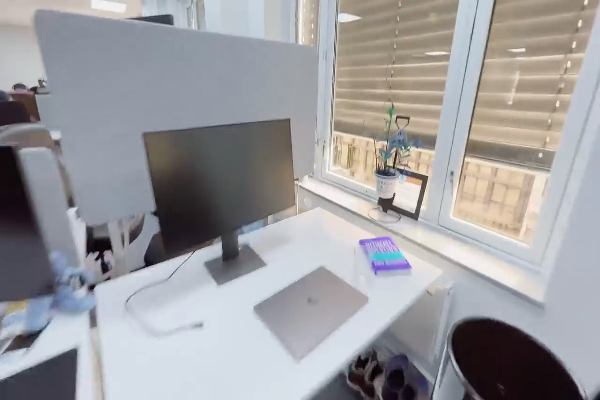

In [21]:
Image.fromarray(frame)